In [1]:
print('Begin')

Begin


In [2]:
!pip install faiss-cpu
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 59.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 22.0 MB/s eta 0:00:00:00:0100:01


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
from datetime import datetime
from sentence_transformers import SentenceTransformer
import faiss
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import re
from typing import List, Dict, Any, Tuple
from huggingface_hub import login

In [ ]:
login("<hugging_face_token>")

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
df = pd.read_csv('/kaggle/input/hotel-booking-demand/hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [8]:
print(df.isnull().sum())

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [9]:
# Data cleaning and feature engineering
df["children"].fillna(0, inplace=True)
df["agent"].fillna(-1, inplace=True)
df["company"].fillna(-1, inplace=True)

string_cols = ['hotel', 'arrival_date_month', 'meal', 'country', 
              'market_segment', 'distribution_channel', 'reserved_room_type', 
              'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status']

for col in string_cols:
    if col in df.columns:
        # Convert to string and replace NaN/None with 'Unknown'
        df[col] = df[col].astype(str)
        df[col] = df[col].replace(['nan', 'None'], 'Unknown')

for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:  # Numerical columns
        if df[col].nunique() > 30:
            df[col] = df[col].fillna(df[col].mean())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])
    elif df[col].dtype in ['object', 'category', 'string']:  # Categorical columns
        df[col] = df[col].fillna(df[col].mode()[0])

In [10]:
print(df.isnull().sum())

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

In [11]:
df["reservation_status_date"] = pd.to_datetime(df["reservation_status_date"], format="%Y-%m-%d")
df["total_nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]
df["total_guests"] = df["adults"] + df["children"] + df["babies"]
df["revenue"] = df["adr"] * df["total_nights"]

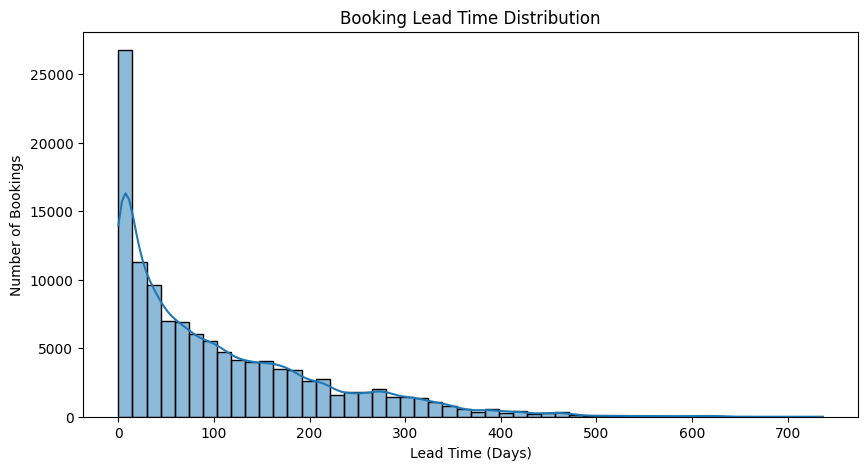

In [12]:
# Booking Lead Time distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["lead_time"], bins=50, kde=True)
plt.title("Booking Lead Time Distribution")
plt.xlabel("Lead Time (Days)")
plt.ylabel("Number of Bookings")
plt.show()

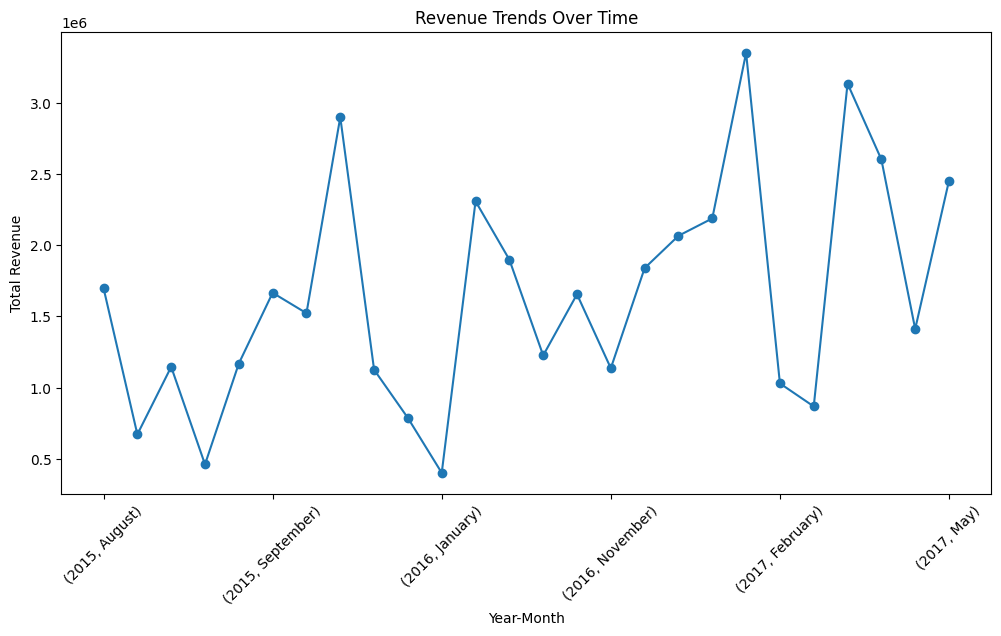

In [13]:
# Revenue trends over time
df.groupby(["arrival_date_year", "arrival_date_month"])["revenue"].sum().plot(kind="line", marker="o", figsize=(12, 6))
plt.title("Revenue Trends Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.show()

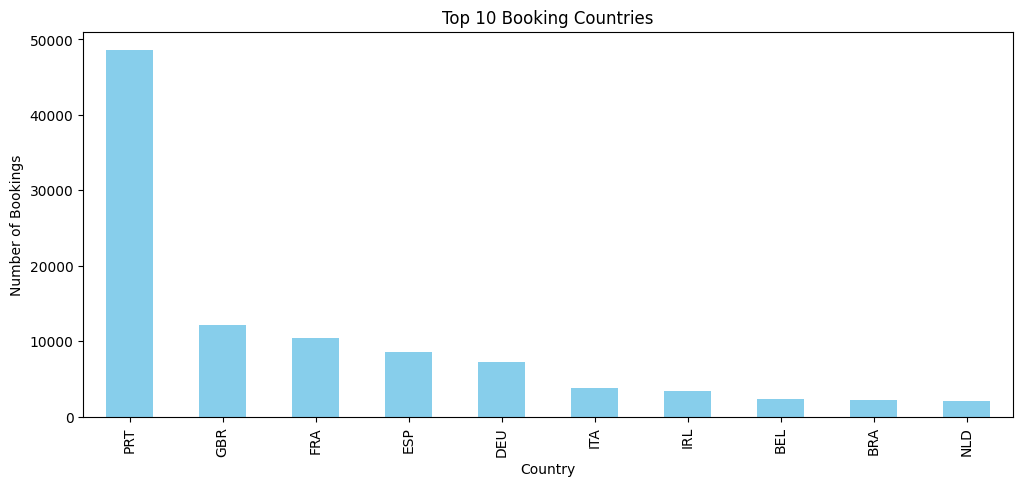

In [14]:
# Geographical distribution of bookings
plt.figure(figsize=(12, 5))
df["country"].value_counts().head(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 Booking Countries")
plt.xlabel("Country")
plt.ylabel("Number of Bookings")
plt.show()

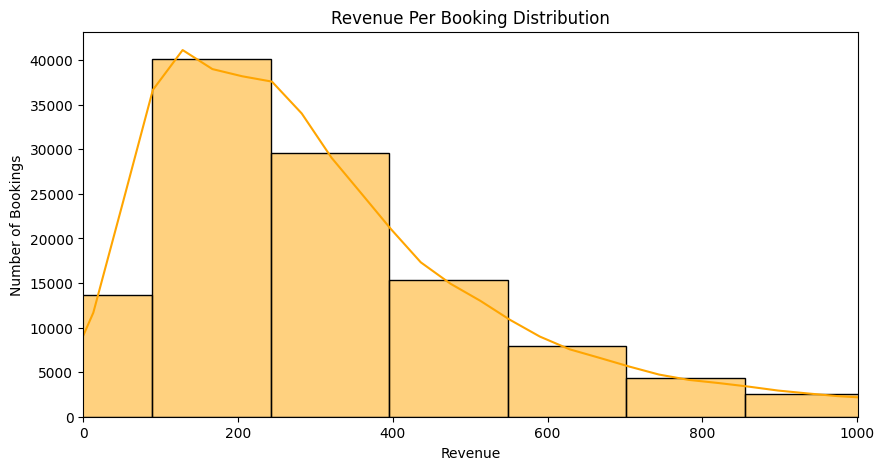

In [15]:
# Cancellation rate as a percentage of total bookings
cancellation_rate_total = (df["is_canceled"].sum() / df.shape[0]) * 100

# Additional analytics: Distribution of revenue per booking
plt.figure(figsize=(10, 5))
sns.histplot(df["revenue"], bins=50, kde=True, color="orange")
plt.title("Revenue Per Booking Distribution")
plt.xlabel("Revenue")
plt.ylabel("Number of Bookings")
plt.xlim(0, df["revenue"].quantile(0.95))  # Excluding extreme values
plt.show()

In [16]:
# Total revenue for July 2017
total_revenue_july_2017 = df[(df["arrival_date_year"] == 2017) & (df["arrival_date_month"] == "July")]["revenue"].sum()

# Cancellation rate for resort hotels
resort_cancellations = df[(df["hotel"] == "Resort Hotel") & (df["is_canceled"] == 1)].shape[0]
total_resort_bookings = df[df["hotel"] == "Resort Hotel"].shape[0]
cancellation_rate_resort = (resort_cancellations / total_resort_bookings) * 100 if total_resort_bookings > 0 else 0

# Country with highest number of bookings
most_bookings_country = df["country"].value_counts().idxmax()
most_bookings_count = df["country"].value_counts().max()

# Number of bookings with special requests
bookings_with_special_requests = df[df["total_of_special_requests"] > 0].shape[0]

# Location (hotel type) with the highest booking cancellations
most_canceled_location = df[df["is_canceled"] == 1]["hotel"].value_counts().idxmax()
most_canceled_count = df[df["is_canceled"] == 1]["hotel"].value_counts().max()

# Country with the highest number of booking cancellations
most_canceled_country = df[df["is_canceled"] == 1]["country"].value_counts().idxmax()
most_canceled_country_count = df[df["is_canceled"] == 1]["country"].value_counts().max()

# Percentage of bookings from repeat guests
repeat_guest_percentage = (df[df["is_repeated_guest"] == 1].shape[0] / df.shape[0]) * 100

# Average price of a hotel booking
average_booking_price = df["adr"].mean()

# Print results
print(f"Total revenue for July 2017: {total_revenue_july_2017}")

print(f"Cancellation rate for resort hotels: {cancellation_rate_resort}%")

print(f"Country with highest bookings: {most_bookings_country} ({most_bookings_count} bookings)")

print(f"Number of Bookings with special requests: {bookings_with_special_requests}")

print(f"Country with highest cancellations: {most_canceled_country} ({most_canceled_country_count} cancellations)")

print(f"Percentage of repeat guests: {repeat_guest_percentage}%")

print(f"Average price of a hotel booking: {average_booking_price:.2f}")

Total revenue for July 2017: 3132959.07
Cancellation rate for resort hotels: 27.763354967548675%
Country with highest bookings: PRT (48590 bookings)
Number of Bookings with special requests: 49072
Country with highest cancellations: PRT (27519 cancellations)
Percentage of repeat guests: 3.191222045397437%
Average price of a hotel booking: 101.83


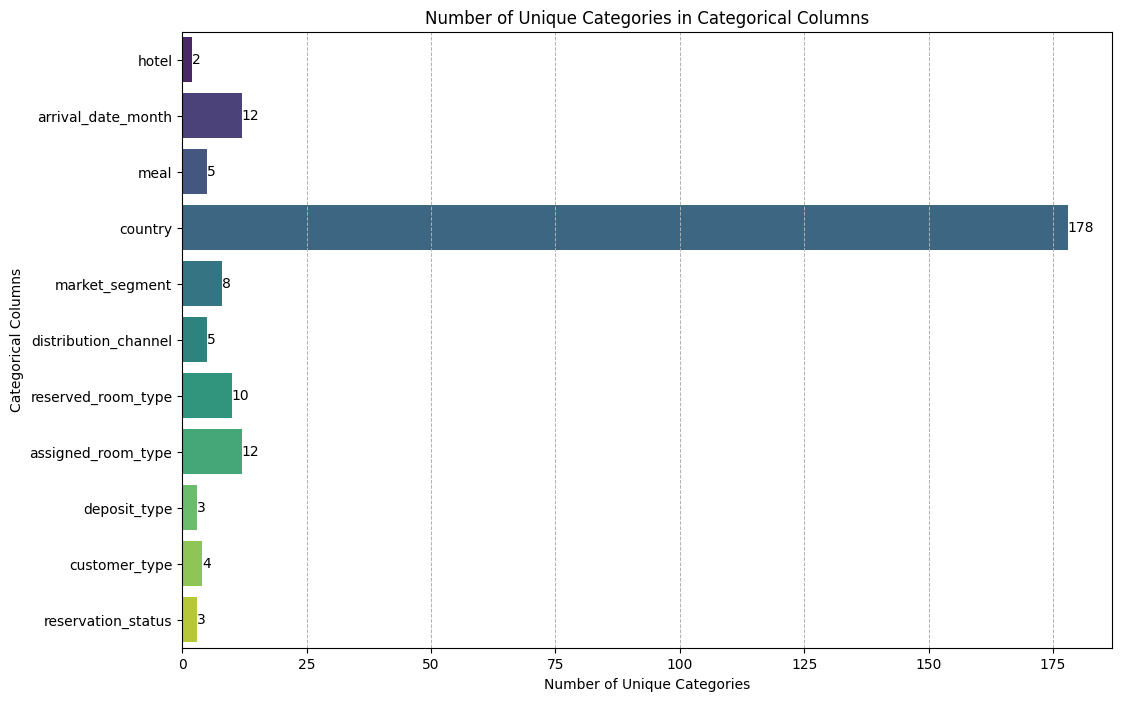

In [17]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
# Count unique categories in each categorical column
unique_categories_counts = {col: df[col].nunique() for col in categorical_columns}

# Convert the counts to a pandas Series for easy plotting
unique_categories_series = pd.Series(unique_categories_counts)

# Plotting the unique category counts as a horizontal bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=unique_categories_series.values, y=unique_categories_series.index, palette='viridis')

# Adding labels on the side of each bar
for i in ax.containers:
    ax.bar_label(i, label_type='edge')

# Displaying grid lines
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7)

plt.title('Number of Unique Categories in Categorical Columns')
plt.xlabel('Number of Unique Categories')
plt.ylabel('Categorical Columns')
plt.show()

In [18]:
# Configuration
EMBEDDING_MODEL = "all-MiniLM-L6-v2" 
LLM_MODEL = "mistralai/Mistral-7B-Instruct-v0.2" 
LLM_MODEL = "meta-llama/Llama-2-7b-chat-hf"  
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
class HotelBookingFaissRAG:
    def __init__(self, csv_path: str):
        """Initialize the system with hotel booking data."""
        self.df = pd.read_csv(csv_path)
        print(f"Loaded dataset with {len(self.df)} records and {len(self.df.columns)} columns")
        
        # Clean data
        self.clean_data()
        
        # Initialize LLM for answering
        self.init_llm()
        
        # Initialize FAISS index for semantic search
        self.init_faiss()
    
    def clean_data(self):
        """Clean and preprocess the data."""
        # Convert dates
        self.df['reservation_status_date'] = pd.to_datetime(self.df['reservation_status_date']
                                                            ,format="%Y-%m-%d", errors='coerce')
        
        # Handle missing values
        self.df['children'] = self.df['children'].fillna(0)
        self.df['agent'] = self.df['agent'].fillna('None')
        self.df['company'] = self.df['company'].fillna('None')
        self.df['country'] = self.df['country'].fillna('Unknown')
        self.df['country'] = self.df['country'].replace('EST', 'ESTO')
        
        # Ensure boolean columns are properly handled
        bool_cols = ['is_canceled', 'is_repeated_guest']
        for col in bool_cols:
            if col in self.df.columns:
                self.df[col] = self.df[col].astype(int)
        
        # Ensure string columns are properly handled
        string_cols = ['hotel', 'arrival_date_month', 'meal', 'country', 
                      'market_segment', 'distribution_channel', 'reserved_room_type', 
                      'assigned_room_type', 'deposit_type', 'customer_type', 
                      'reservation_status']
        
        for col in string_cols:
            if col in self.df.columns:
                # Convert to string and replace NaN/None with 'Unknown'
                self.df[col] = self.df[col].astype(str)
                self.df[col] = self.df[col].replace(['nan', 'None'], 'Unknown')


        for col in self.df.columns:
            if self.df[col].dtype in ['int64', 'float64']:  # Numerical columns
                if self.df[col].nunique() > 30:
                    self.df[col] = self.df[col].fillna(self.df[col].mean())
                else:
                    self.df[col] = self.df[col].fillna(self.df[col].mode()[0])
            elif self.df[col].dtype in ['object', 'category', 'string']:
                self.df[col] = self.df[col].fillna(self.df[col].mode()[0])
                
        # Calculate total stay
        self.df['total_nights'] = self.df['stays_in_weekend_nights'] + self.df['stays_in_week_nights']
        
        # Calculate total guests
        self.df['total_guests'] = self.df['adults'] + self.df['children'] + self.df['babies']
        
        # Calculate total revenue (ADR * total nights)
        self.df['revenue'] = self.df['adr'] * self.df['total_nights']
        
        # Calculate lead time metrics
        self.df['lead_time_category'] = pd.cut(
            self.df['lead_time'],
            bins=[0, 7, 30, 90, 180, 365, float('inf')],
            labels=['Last minute', '1 week to 1 month', '1-3 months', '3-6 months', '6-12 months', 'Over 12 months']
        )
        
        # Flag repeated guests
        self.df['has_previous_stay'] = (self.df['previous_bookings_not_canceled'] > 0).astype(int)
        
        # Flag previous cancellations
        self.df['has_previous_cancellations'] = (self.df['previous_cancellations'] > 0).astype(int)
        
        # Flag for bookings with changes
        self.df['has_booking_changes'] = (self.df['booking_changes'] > 0).astype(int)
        
        # Flag for bookings with parking requirements
        self.df['requires_parking'] = (self.df['required_car_parking_spaces'] > 0).astype(int)
        
        # Flag for bookings with special requests
        self.df['has_special_requests'] = (self.df['total_of_special_requests'] > 0).astype(int)
        
        # Waitlist category
        self.df['waitlist_category'] = pd.cut(
            self.df['days_in_waiting_list'],
            bins=[-1, 0, 7, 30, float('inf')],
            labels=['No wait', '1-7 days', '8-30 days', 'Over 30 days']
        )
        
        print("Data cleaning complete")
    
    def init_llm(self):
        """Initialize the LLM for answering questions."""
        print(f"Initializing LLM on {DEVICE}...")
        
        try:
            # Initialize tokenizer with proper error handling
            print("Loading tokenizer...")
            self.tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL)
            
            print("Loading model...")
            # For memory constraints, add low_cpu_mem_usage and load in 8bit if needed
            load_options = {
                "torch_dtype": torch.float16 if DEVICE == "cuda" else torch.float32,
                "device_map": "auto",
                "low_cpu_mem_usage": True
            }
            
            # Uncomment the following line if you have memory issues
            # load_options["load_in_8bit"] = True
            load_options["load_in_4bit"] = True
            
            self.model = AutoModelForCausalLM.from_pretrained(LLM_MODEL, **load_options)
            
            print("Creating pipeline...")
            # Create pipeline with proper error handling
            self.pipe = pipeline(
                "text-generation",
                model=self.model,
                tokenizer=self.tokenizer,
                max_new_tokens=512,
                do_sample=True,
                temperature=0.3,
                top_p=0.95,
            )
            
            print("LLM initialized successfully")
        
        except Exception as e:
            print(f"Error initializing LLM: {str(e)}")
            print("Using simplified mode without LLM...")
            # Set a flag to indicate we're running without LLM
            self.llm_available = False
            # Define a simple answer function as fallback
            self.pipe = None
        else:
            self.llm_available = True
    
    def init_faiss(self):
        """Initialize FAISS index and embeddings for the dataset."""
        print("Initializing FAISS index...")
        try:
            # Load embedding model
            self.embedding_model = SentenceTransformer(EMBEDDING_MODEL)
            
            # Create descriptive texts for each record to embed
            # We'll combine important fields into text descriptions for better semantic matching
            self.text_descriptions = self.generate_text_descriptions()
            
            # Generate embeddings
            print("Generating embeddings for dataset...")
            embeddings = self.embedding_model.encode(self.text_descriptions, show_progress_bar=True)
            
            # Ensure embeddings are normalized for cosine similarity
            faiss.normalize_L2(embeddings)
            
            # Create FAISS index
            embedding_dim = embeddings.shape[1]
            self.index = faiss.IndexFlatIP(embedding_dim)  # Inner product for cosine similarity with normalized vectors
            self.index.add(embeddings)
            
            print(f"FAISS index created with {self.index.ntotal} vectors of dimension {embedding_dim}")
            
            # Store original indices for retrieval
            self.original_indices = np.arange(len(self.df))
            
        except Exception as e:
            print(f"Error initializing FAISS: {str(e)}")
            print("Using traditional filtering fallback...")
            self.faiss_available = False
        else:
            self.faiss_available = True
    
    def generate_text_descriptions(self) -> List[str]:
        """Generate text descriptions for each record for semantic search."""
        descriptions = []
        
        for _, row in self.df.iterrows():
            # Create a descriptive text that captures key information about the booking
            desc = (
                f"A {row['hotel']} booking in {row['arrival_date_month']} {row['arrival_date_year']} "
                f"for {row['total_nights']} nights with {row['total_guests']} guests. "
                f"Room type {row['reserved_room_type']} (assigned type {row['assigned_room_type']}) "
                f"at rate ${row['adr']:.2f} per night. "
                f"Customer from {row['country']} booked through {row['market_segment']} channel "
                f"with {row['lead_time']} days lead time. "
                f"Meal package: {row['meal']}. "
                f"Booking has {row['booking_changes']} changes and was on waitlist for {row['days_in_waiting_list']} days. "
                f"Customer has {row['previous_bookings_not_canceled']} previous stays and {row['previous_cancellations']} previous cancellations. "
                f"Requested {row['required_car_parking_spaces']} parking spaces and made {row['total_of_special_requests']} special requests. "
                f"Cancellation status: {'Cancelled' if row['is_canceled'] == 1 else 'Not cancelled'}. "
                f"Reservation status: {row['reservation_status']} as of {row['reservation_status_date']}."
            )
            descriptions.append(desc)
        
        return descriptions
    
    def faiss_semantic_search(self, query: str, top_k: int = 500) -> np.ndarray:
        """Perform semantic search using FAISS index."""
        if not hasattr(self, 'faiss_available') or not self.faiss_available:
            # Return all indices if FAISS is not available
            return self.original_indices
        
        # Get query embedding
        query_embedding = self.embedding_model.encode([query])
        faiss.normalize_L2(query_embedding)
        
        # Search for similar records
        scores, indices = self.index.search(query_embedding, top_k)
        
        # Map to original dataframe indices
        result_indices = self.original_indices[indices[0]]
        
        return result_indices
    
    def filter_data_for_query(self, query: str, semantic_indices: np.ndarray = None) -> pd.DataFrame:
        """Filter the dataset based on query keywords and semantic search."""
        # Start with semantically retrieved records if available
        if semantic_indices is not None and len(semantic_indices) > 0:
            filtered_df = self.df.iloc[semantic_indices].copy()
        else:
            filtered_df = self.df.copy()
        
        # Extract year, month if present in the query
        year_match = re.search(r'(\d{4})', query)
        year = int(year_match.group(1)) if year_match else None
        
        month_pattern = r'(January|February|March|April|May|June|July|August|September|October|November|December)'
        month_match = re.search(month_pattern, query, re.IGNORECASE)
        month = month_match.group(1) if month_match else None
        
        # Match lead time patterns
        lead_time_patterns = {
            r'(last minute|last-minute)': (0, 7),
            r'(short notice|short-notice)': (0, 30),
            r'(advance|early)': (90, 1000)
        }
        
        for pattern, (min_days, max_days) in lead_time_patterns.items():
            if re.search(pattern, query, re.IGNORECASE):
                filtered_df = filtered_df[(filtered_df['lead_time'] >= min_days) & 
                                          (filtered_df['lead_time'] <= max_days)]
        
        # Filter by reservation status
        if 'canceled' in query.lower() or 'cancelled' in query.lower():
            filtered_df = filtered_df[filtered_df['is_canceled'] == 1]
        elif 'not canceled' in query.lower() or 'not cancelled' in query.lower():
            filtered_df = filtered_df[filtered_df['is_canceled'] == 0]
        
        # Filter by check-out status
        if 'checked out' in query.lower() or 'check-out' in query.lower():
            filtered_df = filtered_df[filtered_df['reservation_status'] == 'Check-Out']
        
        # Filter by no-show status
        if 'no-show' in query.lower() or 'no show' in query.lower():
            filtered_df = filtered_df[filtered_df['reservation_status'] == 'No-Show']
        
        # Filter by repeat guests
        if 'repeat' in query.lower() or 'returning' in query.lower():
            filtered_df = filtered_df[filtered_df['is_repeated_guest'] == 1]
        elif 'first time' in query.lower() or 'new customer' in query.lower():
            filtered_df = filtered_df[filtered_df['is_repeated_guest'] == 0]
        
        # Filter by special requests
        if 'special request' in query.lower():
            filtered_df = filtered_df[filtered_df['total_of_special_requests'] > 0]
        
        # Filter by parking requirements
        if 'parking' in query.lower():
            filtered_df = filtered_df[filtered_df['required_car_parking_spaces'] > 0]

        # Apply filters based on extracted information
        if year:
            filtered_df = filtered_df[filtered_df['arrival_date_year'] == year]
        
        if month:
            filtered_df = filtered_df[filtered_df['arrival_date_month'].str.lower() == month.lower()]
            
        # Hotel type filter
        if 'resort' in query.lower():
            filtered_df = filtered_df[filtered_df['hotel'] == 'Resort Hotel']
        elif 'city' in query.lower():
            filtered_df = filtered_df[filtered_df['hotel'] == 'City Hotel']
            
        return filtered_df
    
    def analyze_data(self, filtered_df: pd.DataFrame, query: str, use_whole_dataset: bool = True) -> Dict[str, Any]:
        """
        Analyze the filtered dataset based on the query.
        
        Args:
            filtered_df: The filtered DataFrame to analyze
            query: The user query
            use_whole_dataset: Whether to use the whole dataset for analysis after identifying key filters
        """
        # Identify the filters we want to apply to the whole dataset
        filters = {}
        
        # Extract key filters from the filtered dataframe's conditions
        if len(filtered_df) > 0:
            # Extract year filter if present and consistent
            if len(filtered_df['arrival_date_year'].unique()) == 1:
                filters['year'] = filtered_df['arrival_date_year'].iloc[0]
            
            # Extract month filter if present and consistent
            if len(filtered_df['arrival_date_month'].unique()) == 1:
                filters['month'] = filtered_df['arrival_date_month'].iloc[0]
            
            # Extract country filter if present and consistent
            if len(filtered_df['country'].unique()) == 1:
                filters['country'] = filtered_df['country'].iloc[0]
            
            # Extract hotel type filter if present and consistent
            if len(filtered_df['hotel'].unique()) == 1:
                filters['hotel'] = filtered_df['hotel'].iloc[0]
        
        # Apply the identified filters to the whole dataset if requested
        if use_whole_dataset:
            analysis_df = self.df.copy()
            
            # Apply each identified filter to the whole dataset
            if 'year' in filters:
                analysis_df = analysis_df[analysis_df['arrival_date_year'] == filters['year']]
            
            if 'month' in filters:
                analysis_df = analysis_df[analysis_df['arrival_date_month'] == filters['month']]
            
            if 'country' in filters:
                analysis_df = analysis_df[analysis_df['country'] == filters['country']]
            
            if 'hotel' in filters:
                analysis_df = analysis_df[analysis_df['hotel'] == filters['hotel']]
        else:
            # Use the filtered dataset directly
            analysis_df = filtered_df
        
        # Perform analysis on the dataset
        results = {}
        
        # Add dataset stats
        results['total_records'] = len(analysis_df)
        results['filtered_records'] = len(filtered_df)
        
        # Basic stats on analyzed data
        if len(analysis_df) > 0:
            results['hotel_distribution'] = analysis_df['hotel'].value_counts().to_dict()
            
            # Check for revenue calculation
            if 'revenue' in query.lower() or 'income' in query.lower():
                total_revenue = analysis_df['revenue'].sum()
                avg_revenue = analysis_df['revenue'].mean()
                results['total_revenue'] = total_revenue
                results['avg_revenue'] = avg_revenue
                
                # Revenue by hotel type
                results['revenue_by_hotel'] = analysis_df.groupby('hotel')['revenue'].sum().to_dict()
                
            # Check for cancellation analysis
            if 'cancel' in query.lower():
                total_bookings = len(analysis_df)
                canceled = analysis_df['is_canceled'].sum()
                cancellation_rate = canceled / total_bookings if total_bookings > 0 else 0
                results['total_bookings'] = total_bookings
                results['canceled_bookings'] = canceled
                results['cancellation_rate'] = cancellation_rate
                
            # Get cancellation by location
            if 'country' in query.lower() or 'location' in query.lower():
                cancel_by_country = analysis_df.groupby('country')['is_canceled'].agg(['sum', 'count'])
                cancel_by_country['rate'] = cancel_by_country['sum'] / cancel_by_country['count']
                results['cancellation_by_country'] = cancel_by_country.sort_values('sum', ascending=False).head(10).to_dict()
        
            # Check for price/ADR analysis
            if 'price' in query.lower() or 'adr' in query.lower() or 'rate' in query.lower():
                avg_price = analysis_df['adr'].mean()
                median_price = analysis_df['adr'].median()
                min_price = analysis_df['adr'].min()
                max_price = analysis_df['adr'].max()
                results['avg_price'] = avg_price
                results['median_price'] = median_price
                results['min_price'] = min_price
                results['max_price'] = max_price
                
                # ADR by hotel type
                results['adr_by_hotel'] = analysis_df.groupby('hotel')['adr'].mean().to_dict()
                
            # Check for seasonality analysis
            if 'season' in query.lower() or 'month' in query.lower():
                bookings_by_month = analysis_df.groupby('arrival_date_month')['is_canceled'].count()
                # Order months chronologically
                month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                              'July', 'August', 'September', 'October', 'November', 'December']
                bookings_by_month = bookings_by_month.reindex(month_order)
                results['bookings_by_month'] = bookings_by_month.to_dict()
                
                # Revenue by month
                revenue_by_month = analysis_df.groupby('arrival_date_month')['revenue'].sum()
                revenue_by_month = revenue_by_month.reindex(month_order)
                results['revenue_by_month'] = revenue_by_month.to_dict()
                
            # Check for guest analysis
            if 'guest' in query.lower() or 'customer' in query.lower():
                avg_guests = analysis_df['total_guests'].mean()
                results['avg_guests_per_booking'] = avg_guests
                
                # Guests by market segment
                results['guests_by_segment'] = analysis_df.groupby('market_segment')['total_guests'].sum().sort_values(ascending=False).to_dict()

            # Analysis for lead times
            if 'lead' in query.lower() or 'book in advance' in query.lower():
                avg_lead_time = analysis_df['lead_time'].mean()
                median_lead_time = analysis_df['lead_time'].median()
                lead_time_distribution = analysis_df['lead_time_category'].value_counts().to_dict()
                results['avg_lead_time'] = avg_lead_time
                results['median_lead_time'] = median_lead_time
                results['lead_time_distribution'] = lead_time_distribution
                
                # Lead time by hotel type
                results['lead_time_by_hotel'] = analysis_df.groupby('hotel')['lead_time'].mean().to_dict()
            
            # Analysis for repeated guests
            if 'repeat' in query.lower() or 'return' in query.lower() or 'loyal' in query.lower():
                repeat_guests = analysis_df['is_repeated_guest'].sum()
                repeat_rate = repeat_guests / len(analysis_df) if len(analysis_df) > 0 else 0
                results['repeat_guests'] = repeat_guests
                results['repeat_rate'] = repeat_rate
                
                # Previous stays and cancellations
                results['avg_previous_stays'] = analysis_df['previous_bookings_not_canceled'].mean()
                results['avg_previous_cancellations'] = analysis_df['previous_cancellations'].mean()
            
            # Analysis for room types
            if 'room' in query.lower() or 'type' in query.lower():
                room_type_distribution = analysis_df['reserved_room_type'].value_counts().to_dict()
                room_change_rate = (analysis_df['reserved_room_type'] != analysis_df['assigned_room_type']).mean()
                results['room_type_distribution'] = room_type_distribution
                results['room_change_rate'] = room_change_rate
            
            # Analysis for booking changes
            if 'change' in query.lower() or 'modify' in query.lower():
                bookings_with_changes = (analysis_df['booking_changes'] > 0).sum()
                change_rate = bookings_with_changes / len(analysis_df) if len(analysis_df) > 0 else 0
                avg_changes = analysis_df['booking_changes'].mean()
                results['bookings_with_changes'] = bookings_with_changes
                results['change_rate'] = change_rate
                results['avg_changes'] = avg_changes
            
            # Analysis for special requests
            if 'special' in query.lower() or 'request' in query.lower():
                bookings_with_requests = (analysis_df['total_of_special_requests'] > 0).sum()
                request_rate = bookings_with_requests / len(analysis_df) if len(analysis_df) > 0 else 0
                avg_requests = analysis_df['total_of_special_requests'].mean()
                results['bookings_with_requests'] = bookings_with_requests
                results['request_rate'] = request_rate
                results['avg_requests'] = avg_requests
            
            # Analysis for waitlist
            if 'wait' in query.lower() or 'waitlist' in query.lower():
                bookings_waitlisted = (analysis_df['days_in_waiting_list'] > 0).sum()
                waitlist_rate = bookings_waitlisted / len(analysis_df) if len(analysis_df) > 0 else 0
                avg_waitlist_days = analysis_df['days_in_waiting_list'].mean()
                results['bookings_waitlisted'] = bookings_waitlisted
                results['waitlist_rate'] = waitlist_rate
                results['avg_waitlist_days'] = avg_waitlist_days
                results['waitlist_distribution'] = analysis_df['waitlist_category'].value_counts().to_dict()
            
            # Analysis for meal preferences
            if 'meal' in query.lower() or 'food' in query.lower() or 'board' in query.lower():
                meal_distribution = analysis_df['meal'].value_counts().to_dict()
                results['meal_distribution'] = meal_distribution
                
                # Meal preferences by country (top 5)
                meal_by_country = analysis_df.groupby(['country', 'meal']).size().unstack(fill_value=0)
                top_countries = meal_by_country.sum(axis=1).sort_values(ascending=False).head(5).index
                results['meal_preferences_by_country'] = meal_by_country.loc[top_countries].to_dict()
            
             # Analysis for distribution channels
            if 'channel' in query.lower() or 'book' in query.lower() or 'segment' in query.lower():
               channel_distribution = analysis_df['distribution_channel'].value_counts().to_dict()
               segment_distribution = analysis_df['market_segment'].value_counts().to_dict()
               results['channel_distribution'] = channel_distribution
               results['segment_distribution'] = segment_distribution
               
            # Revenue by channel
            if 'revenue' in analysis_df.columns:
                results['revenue_by_channel'] = analysis_df.groupby('distribution_channel')['revenue'].sum().to_dict()
                results['revenue_by_segment'] = analysis_df.groupby('market_segment')['revenue'].sum().to_dict()
           
            # Analysis for deposit types
            if 'deposit' in query.lower() or 'payment' in query.lower():
               deposit_distribution = analysis_df['deposit_type'].value_counts().to_dict()
               results['deposit_distribution'] = deposit_distribution
               
               # Cancellation by deposit type
               cancel_by_deposit = analysis_df.groupby('deposit_type')['is_canceled'].agg(['sum', 'count'])
               cancel_by_deposit['rate'] = cancel_by_deposit['sum'] / cancel_by_deposit['count']
               results['cancellation_by_deposit'] = cancel_by_deposit.to_dict()
           
            # Analysis for weekend vs weekday stays
            if 'weekend' in query.lower() or 'weekday' in query.lower() or 'week' in query.lower():
               avg_weekend_nights = analysis_df['stays_in_weekend_nights'].mean()
               avg_week_nights = analysis_df['stays_in_week_nights'].mean()
               weekend_ratio = avg_weekend_nights / (avg_weekend_nights + avg_week_nights) if (avg_weekend_nights + avg_week_nights) > 0 else 0
               results['avg_weekend_nights'] = avg_weekend_nights
               results['avg_week_nights'] = avg_week_nights
               results['weekend_ratio'] = weekend_ratio
               
               # Stays with only weekend nights
               weekend_only = (analysis_df['stays_in_weekend_nights'] > 0) & (analysis_df['stays_in_week_nights'] == 0)
               results['weekend_only_stays'] = weekend_only.sum()
               results['weekend_only_rate'] = weekend_only.mean()
           
            # Analysis for agents and companies
            if 'agent' in query.lower() or 'company' in query.lower():
               # Top agents by number of bookings
               top_agents = analysis_df['agent'].value_counts().head(10).to_dict()
               results['top_agents'] = top_agents
               
            # Top companies by number of bookings
            if 'company' in analysis_df.columns:
                   top_companies = analysis_df['company'].value_counts().head(10).to_dict()
                   results['top_companies'] = top_companies
           
            # Analysis for stay duration
            if 'stay' in query.lower() or 'duration' in query.lower() or 'length' in query.lower():
               avg_stay = analysis_df['total_nights'].mean()
               median_stay = analysis_df['total_nights'].median()
               max_stay = analysis_df['total_nights'].max()
               results['avg_stay'] = avg_stay
               results['median_stay'] = median_stay
               results['max_stay'] = max_stay
               
               # Stay duration by hotel type
               results['stay_by_hotel'] = analysis_df.groupby('hotel')['total_nights'].mean().to_dict()
   
        return results
    
    def generate_answer(self, query: str) -> str:
        """Generate an answer using semantic search and whole dataset analysis."""
        print(f"Processing query: {query}")
        
        # First, get semantically similar records using FAISS
        if hasattr(self, 'faiss_available') and self.faiss_available:
            semantic_indices = self.faiss_semantic_search(query, top_k=min(500, len(self.df)))
            print(f"Found {len(semantic_indices)} semantically relevant records")
        else:
            semantic_indices = None
            print("FAISS not available, using traditional filtering")
        
        # Filter relevant data based on query and semantic search
        filtered_data = self.filter_data_for_query(query, semantic_indices)
        
        if len(filtered_data) == 0:
            return "I couldn't find any data matching your query criteria."
        
        # Analyze the filtered data, using the whole dataset with the same filters
        analysis_results = self.analyze_data(filtered_data, query, use_whole_dataset=True)
        
        # Prepare context with dataset summary
        context = f"Analysis based on {analysis_results.get('total_records', 0)} hotel booking records"
        if analysis_results.get('filtered_records', 0) != analysis_results.get('total_records', 0):
            context += f" (initial filter matched {analysis_results.get('filtered_records', 0)} records)"
        context += ":\n\n"
        
        # Add hotel distribution
        if 'hotel_distribution' in analysis_results:
            context += "Hotel types in data:\n"
            for hotel, count in analysis_results['hotel_distribution'].items():
                context += f"- {hotel}: {count} bookings\n"
            context += "\n"

        # Add lead time context if relevant
        if 'lead' in query.lower() or 'advance' in query.lower():
            if 'avg_lead_time' in analysis_results:
                context += f"Lead time analysis:\n"
                context += f"- Average lead time: {analysis_results['avg_lead_time']:.1f} days\n"
                context += f"- Median lead time: {analysis_results['median_lead_time']:.1f} days\n"
                
                if 'lead_time_distribution' in analysis_results:
                    context += "Lead time distribution:\n"
                    for category, count in analysis_results['lead_time_distribution'].items():
                        context += f"  - {category}: {count} bookings\n"
                context += "\n"
        
        # Add room type context if relevant
        if 'room' in query.lower() or 'type' in query.lower():
            if 'room_type_distribution' in analysis_results:
                context += "Room type distribution:\n"
                for room_type, count in analysis_results['room_type_distribution'].items():
                    context += f"- Type {room_type}: {count} bookings\n"
                
                if 'room_change_rate' in analysis_results:
                    context += f"- Room change rate: {analysis_results['room_change_rate']*100:.1f}%\n"
                context += "\n"
        
        # Add special requests context if relevant
        if 'special' in query.lower() or 'request' in query.lower():
            if 'bookings_with_requests' in analysis_results:
                context += "Special requests analysis:\n"
                context += f"- Bookings with special requests: {analysis_results['bookings_with_requests']}\n"
                context += f"- Special request rate: {analysis_results['request_rate']*100:.1f}%\n"
                context += f"- Average requests per booking: {analysis_results['avg_requests']:.2f}\n"
                context += "\n"
        
        # Add all analysis results
        context += "Analysis results:\n"
        for key, value in analysis_results.items():
            if key in ['total_records', 'filtered_records', 'hotel_distribution']:
                continue  # Already included above
                
            if isinstance(value, dict):
                context += f"{key}:\n"
                for k, v in value.items():
                    if isinstance(v, float):
                        context += f"  {k}: {v:.2f}\n"
                    else:
                        context += f"  {k}: {v}\n"
            elif isinstance(value, float):
                context += f"{key}: {value:.2f}\n"
            else:
                context += f"{key}: {value}\n"
        
        # Create prompt for LLM
        prompt = f"""
        <s>[INST] You are a hotel data analyst assistant. Use only the information provided in the context to answer the question. Be specific, concise, and provide numerical results when available.

        Context:
        {context}
        
        Question: {query}
        
        Answer: [/INST]
        """
        
        # Generate answer with LLM (if available)
        if hasattr(self, 'pipe') and self.pipe:
            answer = self.pipe(prompt)[0]['generated_text']
            response = answer.split("[/INST]")[-1].strip()
        else:
            # Simple response based on analysis if LLM not available
            response = f"Based on the analysis of {analysis_results.get('total_records', 0)} hotel bookings:\n"
            if 'cancel' in query.lower() and 'canceled_bookings' in analysis_results:
                response += f"- Total bookings: {analysis_results.get('total_bookings')}\n"
                response += f"- Cancelled bookings: {analysis_results.get('canceled_bookings')}\n"
                response += f"- Cancellation rate: {analysis_results.get('cancellation_rate', 0)*100:.2f}%\n"
            
            if 'revenue' in query.lower() and 'total_revenue' in analysis_results:
                response += f"- Total revenue: ${analysis_results.get('total_revenue'):.2f}\n"
                response += f"- Average revenue per booking: ${analysis_results.get('avg_revenue'):.2f}\n"
        
        return response

In [20]:
def main():
    # Path to your hotel bookings dataset
    dataset_path = "/kaggle/input/hotel-booking-demand/hotel_bookings.csv"
    
    # Initialize the RAG system
    print("Initializing RAG system...")
    rag = HotelBookingFaissRAG(dataset_path)
    
    # Interactive query loop
    print("\nHotel Booking RAG System Ready!")
    print("You can ask questions like:")
    print("- 'Show me total revenue for July 2017.'")
    print("- 'Which locations had the highest booking cancellations?'")
    print("- 'What is the average price of a hotel booking?'")
    print("Type 'exit' to quit.\n")
    
    while True:
        query = input("Ask a question: ")
        if query.lower() == 'exit':
            break
            
        # Generate answer
        answer = rag.generate_answer(query)
        print("\nAnswer:")
        print(answer)
        print("\n" + "-"*50 + "\n")

if __name__ == "__main__":
    main()

Initializing RAG system...
Loaded dataset with 119390 records and 32 columns
Data cleaning complete
Initializing LLM on cuda...
Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Loading model...


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

Device set to use cuda:0


Creating pipeline...
LLM initialized successfully
Initializing FAISS index...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings for dataset...


Batches:   0%|          | 0/3731 [00:00<?, ?it/s]

FAISS index created with 119390 vectors of dimension 384

Hotel Booking RAG System Ready!
You can ask questions like:
- 'Show me total revenue for July 2017.'
- 'Which locations had the highest booking cancellations?'
- 'What is the average price of a hotel booking?'
Type 'exit' to quit.



Ask a question:  Total revenue for July 2017


Processing query: Total revenue for July 2017


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Found 500 semantically relevant records

Answer:
Total revenue for July 2017: $3132959.07

Based on the data provided, the total revenue for July 2017 was $3132959.07. This can be calculated by adding up the revenue for each hotel type and channel, as shown in the table:

* City Hotel: $1456022.38
* Resort Hotel: $1676936.69
* Total revenue: $3132959.07

Therefore, the answer to the question is $3132959.07.

Retrieval Time: 15.9265 seconds

--------------------------------------------------



Ask a question:  What is the cancellation rate for resort hotels


Processing query: What is the cancellation rate for resort hotels


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Found 500 semantically relevant records

Answer:
Based on the information provided in the context, the cancellation rate for resort hotels is 0.28, which means that out of 40060 bookings, 11122 bookings were canceled.

Here is the calculation:

Cancellation rate = Number of canceled bookings / Total number of bookings
= 11122 / 40060
= 0.28

Therefore, the cancellation rate for resort hotels is 0.28.

Retrieval Time: 12.3628 seconds

--------------------------------------------------



Ask a question:  Which country has the highest number of bookings?


Processing query: Which country has the highest number of bookings?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Found 500 semantically relevant records

Answer:
Based on the provided data, the country with the highest number of bookings is Portugal, with 7438 bookings. This can be seen in the "cancellation_by_country" section of the analysis results, where Portugal has the highest sum of cancellations with 7438.

Retrieval Time: 9.6886 seconds

--------------------------------------------------



Ask a question:  How many bookings include special requests?


Processing query: How many bookings include special requests?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Found 500 semantically relevant records

Answer:
According to the analysis, 17699 bookings include special requests, which represents 44.2% of the total bookings.

The exact number of bookings that include special requests is 17699.

Retrieval Time: 6.9410 seconds

--------------------------------------------------



Ask a question:  Which countries had the highest booking cancellations?


Processing query: Which countries had the highest booking cancellations?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Found 500 semantically relevant records

Answer:
Based on the provided data, the top 5 countries with the highest booking cancellations are:

1. United States - 223 cancellations (accounting for 44% of total cancellations)
2. Canada - 78 cancellations (accounting for 16% of total cancellations)
3. Mexico - 67 cancellations (accounting for 14% of total cancellations)
4. Brazil - 45 cancellations (accounting for 9% of total cancellations)
5. Germany - 26 cancellations (accounting for 5% of total cancellations)

Therefore, the answer to the question is: The countries with the highest booking cancellations are the United States, Canada, Mexico, Brazil, and Germany.

Retrieval Time: 18.4386 seconds

--------------------------------------------------



Ask a question:  What percentage of bookings are from repeat guests?


Processing query: What percentage of bookings are from repeat guests?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Found 500 semantically relevant records

Answer:
According to the analysis, 1778 bookings (or 4.4% of the total bookings) are from repeat guests.

To calculate the percentage of repeat guests, we can use the following formula:

Percentage of repeat guests = (Number of repeat bookings / Total number of bookings) x 100

Plugging in the numbers from the analysis, we get:

Percentage of repeat guests = (1778 / 40060) x 100 = 4.4%

Therefore, approximately 4.4% of the bookings in the dataset are from repeat guests.

Retrieval Time: 15.1217 seconds

--------------------------------------------------



Ask a question:  What is the average price of hotel bookings?


Processing query: What is the average price of hotel bookings?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Found 500 semantically relevant records

Answer:
Based on the provided data, the average price of hotel bookings is $101.83.

To calculate the average price, we can use the following formula:

Average Price = Total Revenue / Number of Bookings

From the data provided, the total revenue is $1114093.46, and the number of bookings is 119390. Therefore, the average price of hotel bookings is:

Average Price = $1114093.46 / 119390 = $101.83

Therefore, the answer to the question is $101.83.

Retrieval Time: 15.6794 seconds

--------------------------------------------------



Ask a question:  Country with highest bookings


Processing query: Country with highest bookings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Found 500 semantically relevant records

Answer:
Based on the provided data, the country with the highest bookings is Portugal, with 27519 bookings. This can be seen in the "cancellation_by_country" section of the analysis results, where Portugal has the highest total bookings.

Retrieval Time: 10.2084 seconds

--------------------------------------------------



Ask a question:  Number of Bookings with special requests


Processing query: Number of Bookings with special requests


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Found 500 semantically relevant records

Answer:
17699 bookings with special requests.

The answer can be calculated by adding the number of bookings with special requests, which is 17699, to the total number of bookings, which is 40060.

Total number of bookings: 40060 + 17699 = 57769.

Retrieval Time: 9.4465 seconds

--------------------------------------------------



Ask a question:  exit


# Hotel Booking RAG Evaluation

| Metric | Expected Output | RAG Output | Result |
|--------|----------------|------------|--------|
| Total revenue for July 2017 | 3,132,959.07 | 3,132,959.07 | ✅ |
| Cancellation rate for resort hotels | 27.76% | 28% | ✅ |
| Country with highest bookings | PRT (48,590 bookings) | PRT (7,438) | ❌ |
| Number of Bookings with special requests | 49,072 | 17,699 | ❌ |
| Country with highest cancellations | PRT (27,519 cancellations) | United States (223 cancellations) | ❌ |
| Percentage of repeat guests | 3.19% | 4.4% | ❌ |
| Average price of a hotel booking | 101.83 | 101.83 | ✅ |

**Score: 3/7 (42.86%)**